In [1]:
# here we quantify the finetune of previous notebook (finetune_2models2styles)

In [1]:
import numpy as np
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F

import textwrap

from transformers import AutoModelForCausalLM, AutoTokenizer
from torchinfo import summary
import requests

/Users/raeez/.pyenv/versions/jupyter-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


tokenize and find most freq 100 tokensm

In [2]:
# Eletuther's tokenizer
tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125m')
tokenizer.pad_token_id = tokenizer.encode(' ')[0]

# load in 2 GPTneos and push to GPU
modelAlice = AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125m')
modelEdgar = AutoModelForCausalLM.from_pretrained('EleutherAI/gpt-neo-125m')

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
modelAlice = modelAlice.to(device)
modelEdgar = modelEdgar.to(device)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Loading weights: 100%|█| 160/160 [00:00<00:00, 1658.53it/s, Materializing param=
GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125m
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Loading weights: 100%|█| 160/160 [00:00<00:00, 1549.41it/s, Materializing param=
GPTNeoForCausalLM LOAD REPORT from: Eleut

Import text

In [3]:
# throught the looking glass (aka alice in wonderland)
text = requests.get('https://www.gutenberg.org/cache/epub/11/pg11.txt').text
aliceTokens = torch.tensor(tokenizer.encode(text), dtype=torch.long)

# edgar allan Poe
text = requests.get('https://www.gutenberg.org/cache/epub/2148/pg2148.txt').text
edgarTokens = torch.tensor(tokenizer.encode(text), dtype=torch.long)

Token indices sequence length is longer than the specified maximum sequence length for this model (52954 > 2048). Running this sequence through the model will result in indexing errors


Find the most freq tokens

In [4]:
# create a filtered token vector init to zeros
aliceTokensFilt = np.full(len(aliceTokens),-1,dtype=int)
# this filter will have the tokens if the token has >2char, or else -1

# copy overt the token only if it has >2 char
for t in range(len(aliceTokens)):
    if len(tokenizer.decode(aliceTokens[t])) > 2:
        aliceTokensFilt[t] = aliceTokens[t]

# repeat for edgar

edgarTokensFilt = np.full(len(edgarTokens),-1,dtype=int)

# copy overt the token only if it has >2 char
for t in range(len(edgarTokens)):
    if len(tokenizer.decode(edgarTokens[t])) > 2:
        edgarTokensFilt[t] = edgarTokens[t]


In [5]:
print(aliceTokensFilt.shape)
print(aliceTokens.shape)

(52954,)
torch.Size([52954])


In [6]:
# print('Edgar:')
print(f'{(edgarTokensFilt==-1).sum()}/{len(edgarTokensFilt)} ({100*(edgarTokensFilt==-1).sum()/len(edgarTokensFilt)}) tokens have <3 chara')
print(f'{(aliceTokensFilt==-1).sum()}/{len(aliceTokensFilt)} ({100*(aliceTokensFilt==-1).sum()/len(aliceTokensFilt)}) tokens have <3 chara')

96190/197306 (48.75168519963914) tokens have <3 chara
24017/52954 (45.35445858669789) tokens have <3 chara


In [7]:
# for ALice
uniq, counts = np.unique(aliceTokensFilt, return_counts =True)
freqidx = np.argsort(counts)[::-1]
top100Alice = uniq[freqidx[1:101]]  # IMP: we take from 1 not 0, because in 0th position we will have -1 in the filter

# for Edgar
uniq, counts = np.unique(edgarTokensFilt, return_counts =True)
freqidx = np.argsort(counts)[::-1]
top100Edgar = uniq[freqidx[1:101]]

for t in top100Alice:
    print(f'Token {t:5} appears {np.sum(aliceTokensFilt==t):4} times and is {tokenizer.decode([t])}')

Token   262 appears 1621 times and is  the
Token   284 appears  763 times and is  to
Token   290 appears  759 times and is  and
Token   286 appears  582 times and is  of
Token   340 appears  504 times and is  it
Token   673 appears  469 times and is  she
Token   531 appears  445 times and is  said
Token   287 appears  396 times and is  in
Token   345 appears  374 times and is  you
Token   373 appears  334 times and is  was
Token 14862 appears  331 times and is  Alice
Token   326 appears  256 times and is  that
Token   355 appears  241 times and is  as
Token   607 appears  233 times and is  her
Token   351 appears  209 times and is  with
Token   379 appears  203 times and is  at
Token   319 appears  190 times and is  on
Token   477 appears  176 times and is  all
Token   550 appears  169 times and is  had
Token   307 appears  161 times and is  be
Token   329 appears  147 times and is  for
Token   407 appears  146 times and is  not
Token   428 appears  145 times and is  this
Token   393 a

In [8]:

for t in top100Edgar:
    print(f'Token {t:5} appears {np.sum(edgarTokensFilt==t):4} times and is {tokenizer.decode([t])}')

Token   262 appears 6895 times and is  the
Token   286 appears 4470 times and is  of
Token   290 appears 2703 times and is  and
Token   284 appears 2154 times and is  to
Token   287 appears 1905 times and is  in
Token   326 appears 1129 times and is  that
Token   373 appears 1063 times and is  was
Token   340 appears  892 times and is  it
Token   616 appears  890 times and is  my
Token   351 appears  829 times and is  with
Token   543 appears  787 times and is  which
Token   355 appears  759 times and is  as
Token   550 appears  741 times and is  had
Token   318 appears  682 times and is  is
Token   379 appears  671 times and is  at
Token   407 appears  603 times and is  not
Token   465 appears  529 times and is  his
Token   329 appears  523 times and is  for
Token   422 appears  517 times and is  from
Token   428 appears  505 times and is  this
Token   383 appears  493 times and is  The
Token   416 appears  485 times and is  by
Token  2402 appears  481 times and is  upon
Token   502 a

Quantify common token usage pretraining

In [9]:
numreps = 10 # num random repetitions
numtoks = 100 # output length

#init
tokenUsageAlice = np.zeros((2,2)) # [pre/post, Alice/Edgar]  This variable corresp to Alice text
tokenUsageEdgar = np.zeros((2,2)) # [pre/post, Alice/Edgar] This variable corresp to Edgar text

# rand start tokens
randstarts = torch.randint(tokenizer.vocab_size, (numreps,1)).to(device)

# ALICE: generate and store tokens
outAlice  = modelAlice.generate(randstarts,
                                min_length = numtoks+1,
                                max_length = numtoks +1,
                                do_sample = True,
                                pad_token_id = tokenizer.pad_token_id).cpu()
genTokensAlice = outAlice[:,1:].reshape(-1)

# EDAGR: smae as above but compressed
outEdgar = modelEdgar.generate(randstarts, min_length=numtoks+1, max_length=numtoks+1, do_sample=True, pad_token_id = tokenizer.pad_token_id).cpu()
genTokensEdgar = outEdgar[:,1:].reshape(-1)

# calculate the percent
tokenUsageAlice[0,0] = np.mean (100*np.isin(genTokensAlice,top100Alice))  # ALice Model, ALice tokens
tokenUsageAlice[0,1] = np.mean (100*np.isin(genTokensEdgar,top100Alice)) # Edgar model, Alice tokens


tokenUsageEdgar[0,0] = np.mean (100*np.isin(genTokensAlice,top100Edgar))  # ALice Model, Edgar tokens
tokenUsageEdgar[0,1] = np.mean (100*np.isin(genTokensEdgar,top100Edgar)) # Edgar model, Edgartokens

tokenUsageEdgar

array([[27.7, 27.8],
       [ 0. ,  0. ]])

Fine tune the models

In [10]:
# ALICE optmizer
optimizerAlice = torch.optim.AdamW(modelAlice.parameters(), lr=5e-5, weight_decay=.01)
optimizerEdgar = torch.optim.AdamW(modelEdgar.parameters(), lr=5e-5, weight_decay=.01)

In [11]:
seq_len = 256
batch_size = 16
num_samples = 100


In [12]:
tokenProbs = np.zeros((num_samples,3))

lossAlice = np.zeros(num_samples)
lossEdgar = np.zeros(num_samples)

for sampli in range(num_samples):
    # init batch losses to accumulate

    # ALICE fine tuning
    # get a batch of data
    ix = torch.randint(len(aliceTokens)-seq_len, size = (batch_size,))
    X = aliceTokens[ix[:,None] + torch.arange(seq_len)].to(device)

    #fwd pass and get loss
    modelAlice.zero_grad()
    outputs = modelAlice(X, labels=X)

    # backprop and store loss
    outputs.loss.backward()
    optimizerAlice.step()
    lossAlice[sampli] = outputs.loss.item()


    #EDGAR fine tuning
    ix = torch.randint(len(edgarTokens)-seq_len, size = (batch_size,))
    X = edgarTokens[ix[:,None] + torch.arange(seq_len)].to(device)

    #fwd pass and get loss
    modelEdgar.zero_grad()
    outputs = modelEdgar(X, labels=X)

    # backprop and store loss
    outputs.loss.backward()
    optimizerAlice.step()
    lossEdgar[sampli] = outputs.loss.item()

    if sampli%25==0:
        print(f'Sample: {sampli}/{num_samples}, losses (Alice/eDgar): {lossAlice[sampli]} / {lossEdgar[sampli]}')

Sample: 0/100, losses (Alice/eDgar): 2.5445785522460938 / 2.7452266216278076
Sample: 25/100, losses (Alice/eDgar): 1.9315093755722046 / 2.618189811706543
Sample: 50/100, losses (Alice/eDgar): 1.6255204677581787 / 2.599311351776123
Sample: 75/100, losses (Alice/eDgar): 1.413282871246338 / 2.5971686840057373


Evaluating the fine tuning

In [14]:

# rand start tokens
randstarts = torch.randint(tokenizer.vocab_size, (numreps,1)).to(device)

# ALICE: generate and store tokens
outAlice  = modelAlice.generate(randstarts,
                                min_length = numtoks+1,
                                max_length = numtoks +1,
                                do_sample = True,
                                pad_token_id = tokenizer.pad_token_id).cpu()
genTokensAlice = outAlice[:,1:].reshape(-1)

# EDAGR: smae as above but compressed
outEdgar = modelEdgar.generate(randstarts, min_length=numtoks+1, max_length=numtoks+1, do_sample=True, pad_token_id = tokenizer.pad_token_id).cpu()
genTokensEdgar = outEdgar[:,1:].reshape(-1)

# calculate the percent
tokenUsageAlice[1,0] = np.mean (100*np.isin(genTokensAlice,top100Alice))  # ALice Model, ALice tokens
tokenUsageAlice[1,1] = np.mean (100*np.isin(genTokensEdgar,top100Alice)) # Edgar model, Alice tokens


tokenUsageEdgar[1,0] = np.mean (100*np.isin(genTokensAlice,top100Edgar))  # ALice Model, Edgar tokens
tokenUsageEdgar[1,1] = np.mean (100*np.isin(genTokensEdgar,top100Edgar)) # Edgar model, Edgartokens

tokenUsageEdgar

array([[27.7, 27.8],
       [23.7, 30.3]])

TypeError: only length-1 arrays can be converted to Python scalars

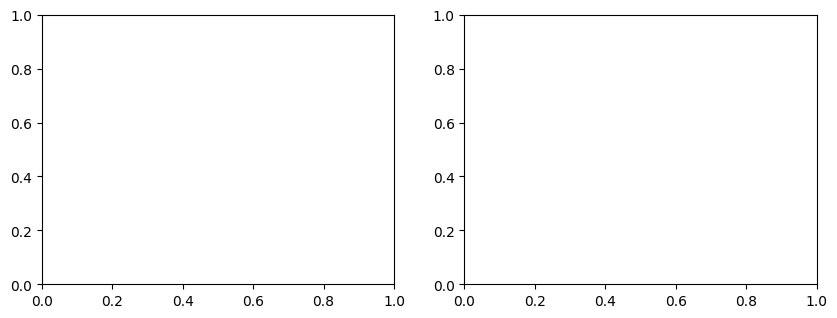

In [15]:
_,axs = plt.subplots(1,2,figsize=(10,3.5))

axs[0].bar([.8,1.8],tokenUsageAlice[0:], width=.4, label='Alice tokens')
axs[0].bar([1.2,2.2],tokenUsageEdgar[0:], width=.4, label='Edgar tokens')
minmaxY = np.sort(np.concatenate((tokenUsageAlice[0,:], tokenUsageEdgar[0,:])))[[0,-2]]
axs

In [34]:
![title]("../images/Edgar_Alice_bar.png")

zsh:1: unknown file attribute: i


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'/Volumes/Storage/Learning & Development/NLP_LLM_Fundamentals/finetune'

Qualitative Assesment

In [30]:
x = tokenizer.encode('What did the Red Queen say to Alice', return_tensors='pt').to(device)

outAlice = modelAlice.generate(x,max_new_tokens=120, do_sample=True,pad_token_id=50257)
outEdgar = modelEdgar.generate(x,max_new_tokens=120, do_sample=True,pad_token_id=50257)

print('** Alice model says:')
print(tokenizer.decode(outAlice[0].cpu()))


print('** Edgar model says:')
print(tokenizer.decode(outEdgar[0].cpu()))

** Alice model says:
What did the Red Queen say to Alice?” she asked.

The Gryphon immediately drew its right elbow impatiently, as if
watching her. “What is it, then?” it began.

“Oh, nothing—you’ve got to speak English,” said the Gryphon hurriedly,
without waiting for an answer: for, as the Mock Turtle began to hum
violently after her, one by one all the time in a large circle, the
Gryphon turned and went on so far up
** Edgar model says:
What did the Red Queen say to Alice who was in love with her on Alice Day?

Alice was the first to get the idea and had to give Alice a heartwarming hug, then she had to give away one heart.

Alice’s heart had to go down a new path to become one with her heart, that she would not miss and that her heart would fly to her feet. She was her heart that Alice would never forget. She was in love with Alice on that day.

She would lose her heart to this thing called Alice and then she would lose her heart to this man in love with


In [ ]:
)